### Load packages

In [1]:
import scanpy as sc
import episcanpy.api as epi
import numpy as np
import anndata as ad
import random
import copy
import pandas as pd

/home/icb/anna.danese/.local/lib/python3.7/site-packages/scanpy/api/__init__.py:7: FutureWarning: 

In a future version of Scanpy, `scanpy.api` will be removed.
Simply use `import scanpy as sc` and `import scanpy.external as sce` instead.

  FutureWarning,


In [2]:
sc.settings.set_figure_params(dpi=80, color_map='gist_earth')

# Pre-processing 10x
We need to filter the barcodes. 

### Load the 10x windows count matrix

In [3]:
input_dir_10x = './data_integration_datasets/10x/merged_peaks_large/'

adata = ad.read(input_dir_10x+'atac_v1_adult_brain_fresh_5k_fragments_AllCells.h5ad')
adata

AnnData object with n_obs × n_vars = 335609 × 787157

In [6]:
with open('./integration_benchmarking/resubmission/filtered_peak_bc_matrix/barcodes.tsv') as f:
    barcodes = f.readlines()
    barcodes = [x.rstrip('\n') for x in barcodes]

annot = []
for name in adata.obs_names.tolist():
    if name in barcodes:
        annot.append('keep')
    else:
        annot.append('discard')
adata.obs['filter_barcode_cellranger'] = annot

adata = adata[adata.obs['filter_barcode_cellranger']=='keep',:].copy()
adata

AnnData object with n_obs × n_vars = 3880 × 787157 
    obs: 'filter_barcode_cellranger'

In [7]:
print(np.max(adata.X))
epi.pp.binarize(adata)
print(np.max(adata.X))

33.0
1.0


In [8]:
epi.pp.filter_cells(adata, min_features=100)
adata

AnnData object with n_obs × n_vars = 3879 × 787157 
    obs: 'filter_barcode_cellranger', 'nb_features'

In [9]:
epi.pp.filter_features(adata, min_cells=10)
adata

AnnData object with n_obs × n_vars = 3879 × 747343 
    obs: 'filter_barcode_cellranger', 'nb_features'
    var: 'n_cells'

In [10]:
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 3879 × 747343 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'filter_barcode_cellranger' as categorical


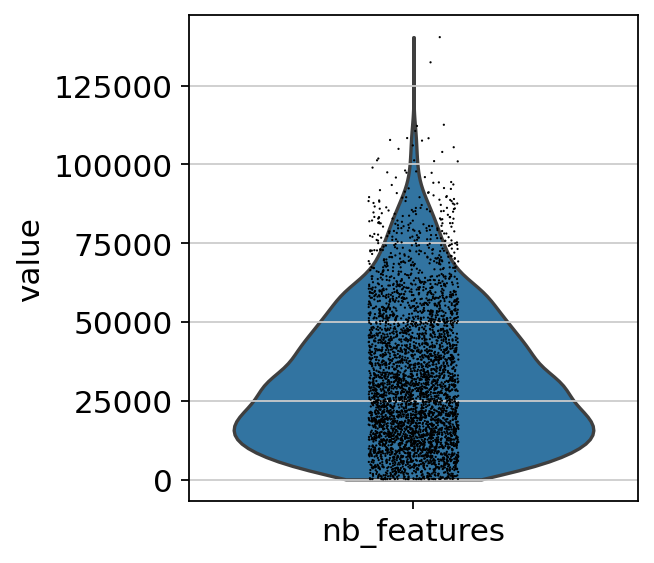

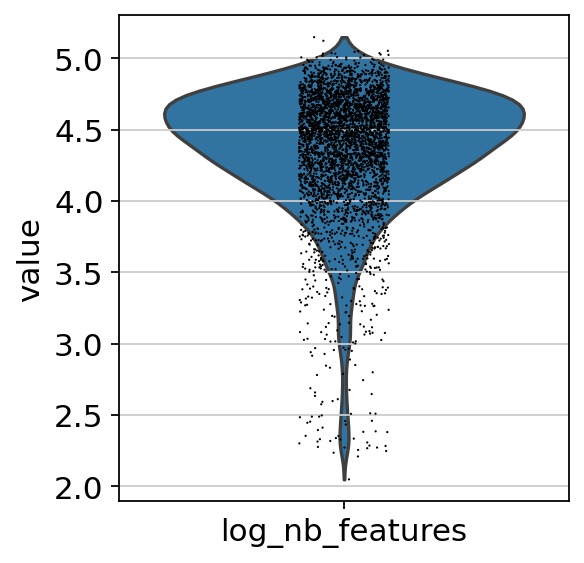

In [11]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

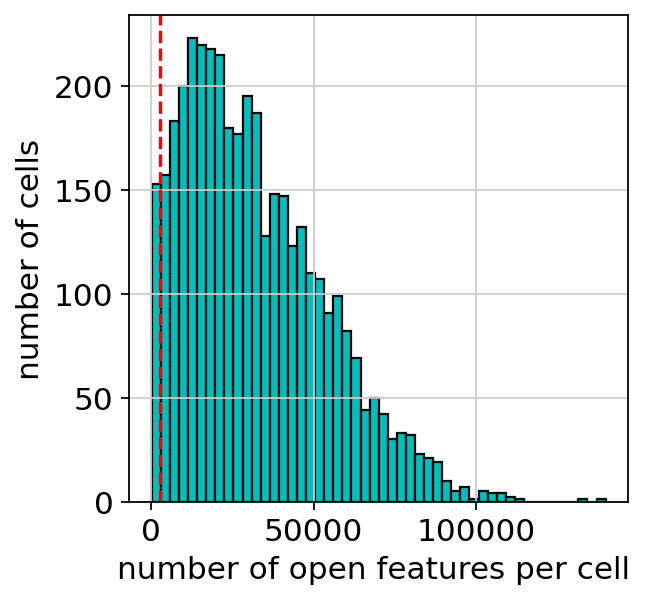

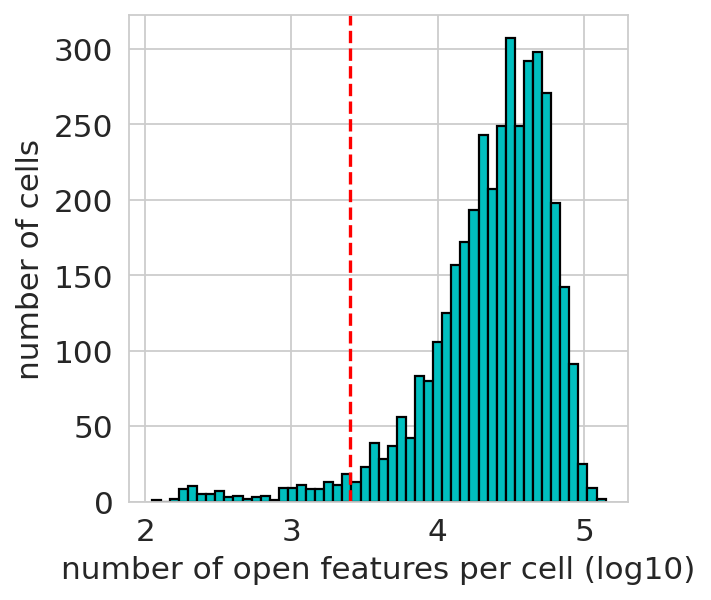

In [12]:
# set a minimum number of cells to keep 
min_features = 2500

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features, save='10x_large_peaks_coverage_cells.png')
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features, save='10x_large_peaks_coverage_cells_log10.png')

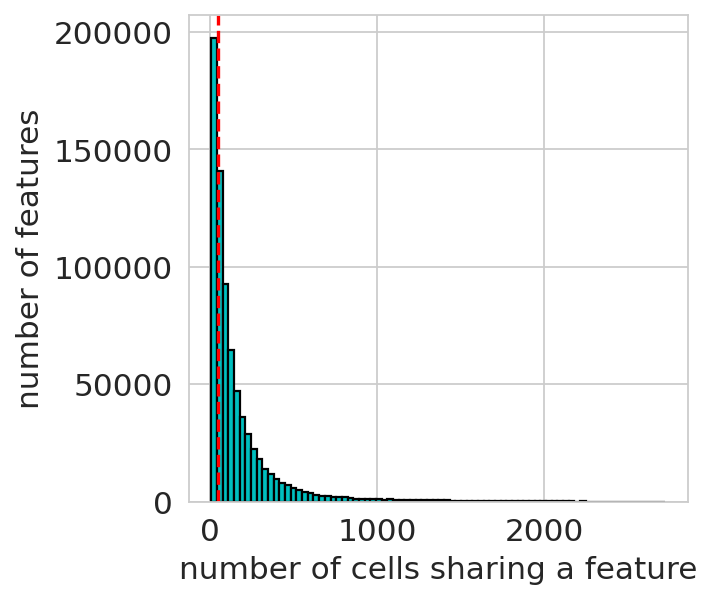

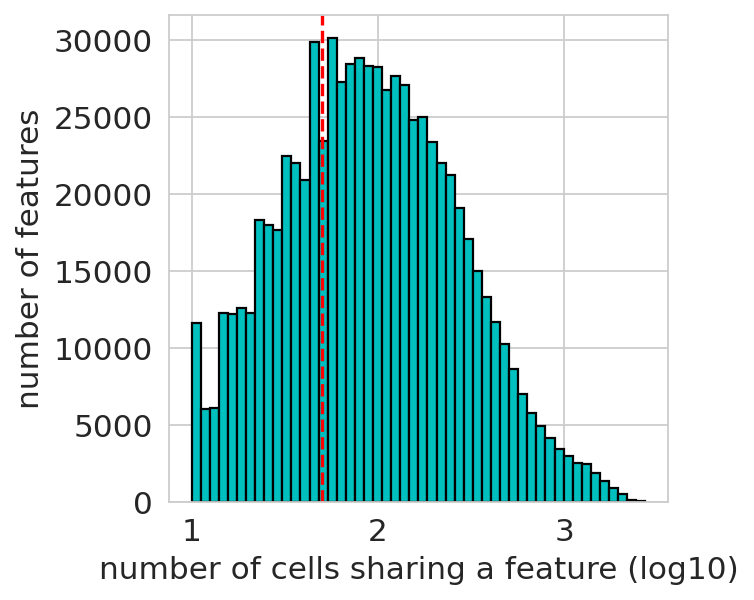

In [13]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_large_peaks_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_large_peaks_coverage_log10.png')

In [14]:
min_features = 2500
epi.pp.filter_cells(adata, min_features=min_features)
adata

AnnData object with n_obs × n_vars = 3739 × 747343 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

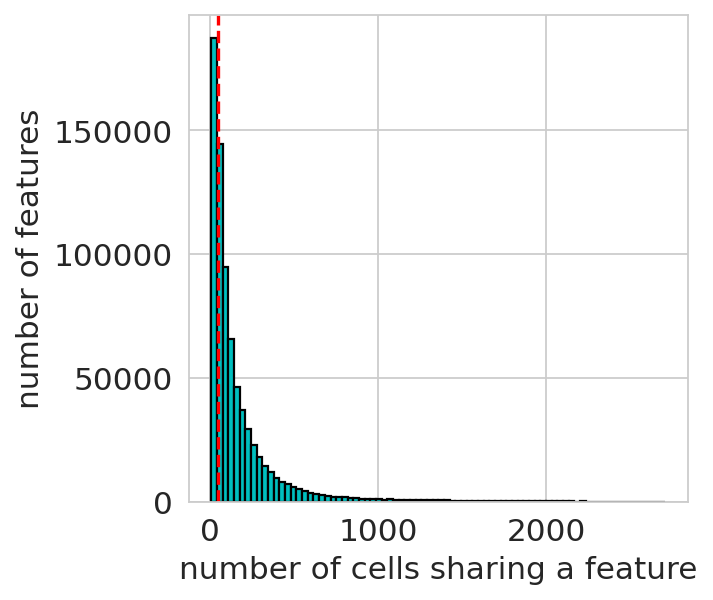

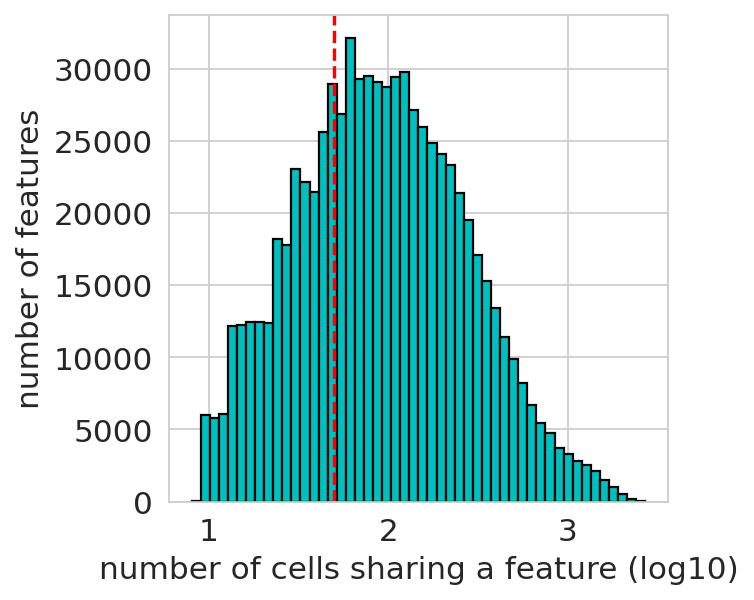

In [15]:
# minimum number of cells sharing a feature
min_cells = 50
epi.pp.coverage_features(adata, binary=True, log=False, 
                        threshold=min_cells, save='10x_large_peaks_coverage.png')
epi.pp.coverage_features(adata, binary=True, log=True, 
                        threshold=min_cells, save='10x_large_peaks_coverage_log10.png')

In [16]:
min_cells = 50
epi.pp.filter_features(adata, min_cells=min_cells)
adata

AnnData object with n_obs × n_vars = 3739 × 520205 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

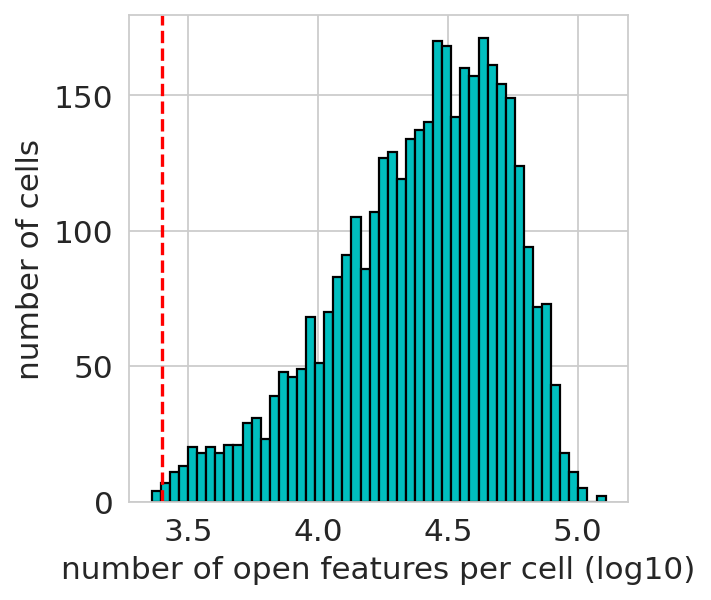

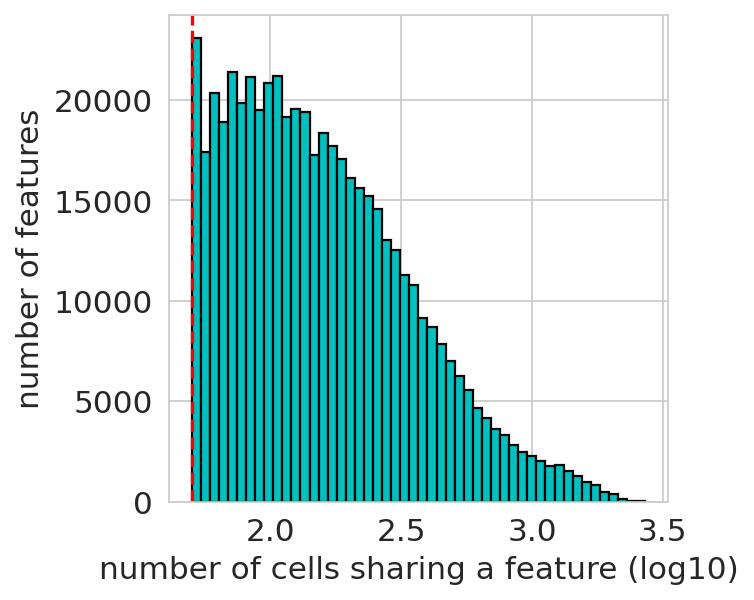

In [17]:
epi.pp.coverage_cells(adata, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata, binary=True, log='log10', bins=50, threshold=min_cells)

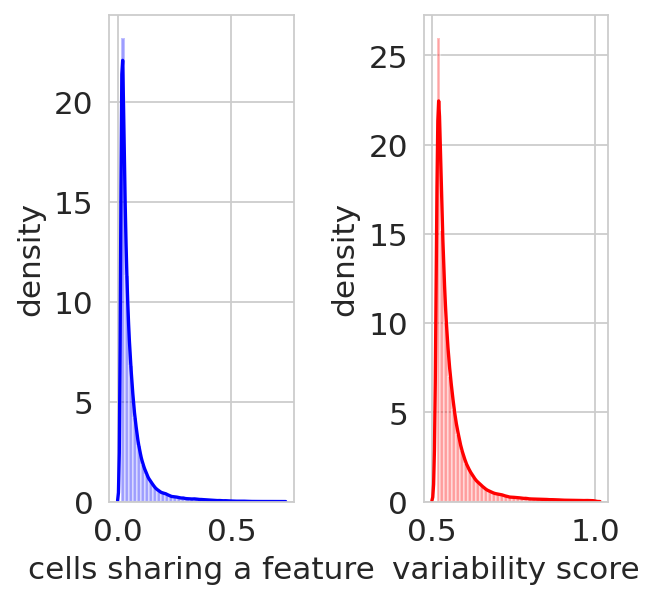

In [18]:
epi.pp.cal_var(adata)

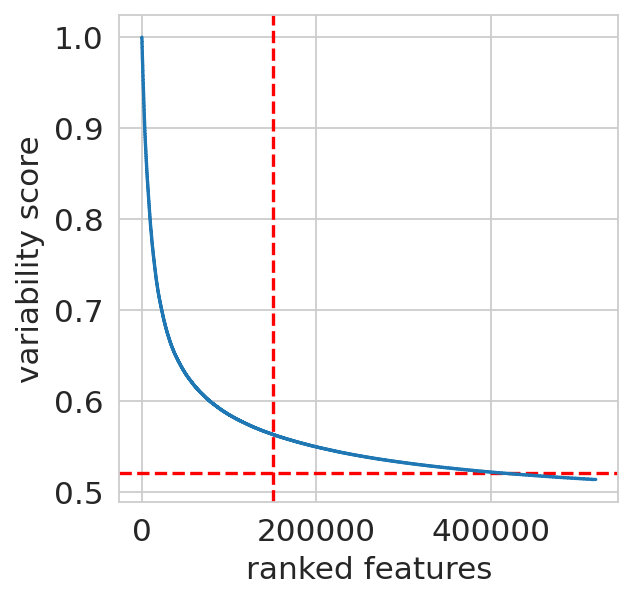

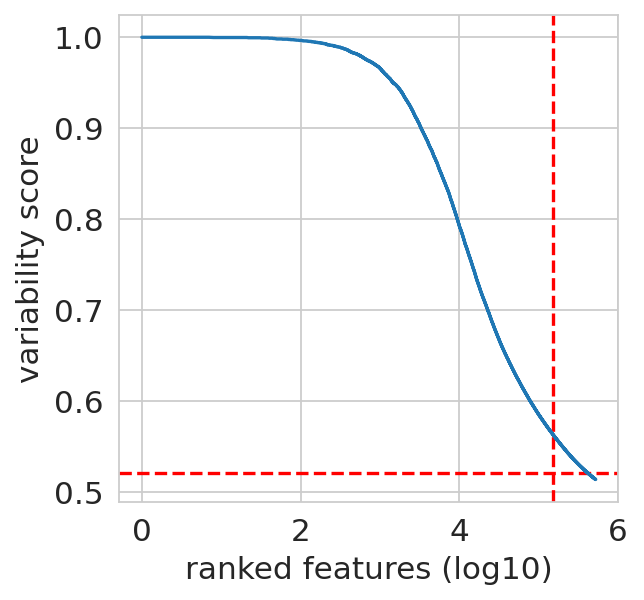

In [19]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_large_peaks.png')

epi.pl.variability_features(adata,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_10x_large_peaks_log10.png')

In [20]:
# save the current matrix in the raw layer
adata.raw = adata

In [21]:
# create a new AnnData containing only the most variable features
adata = epi.pp.select_var_feature(adata,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

In [22]:
adata

View of AnnData object with n_obs × n_vars = 3739 × 150651 
    obs: 'filter_barcode_cellranger', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'

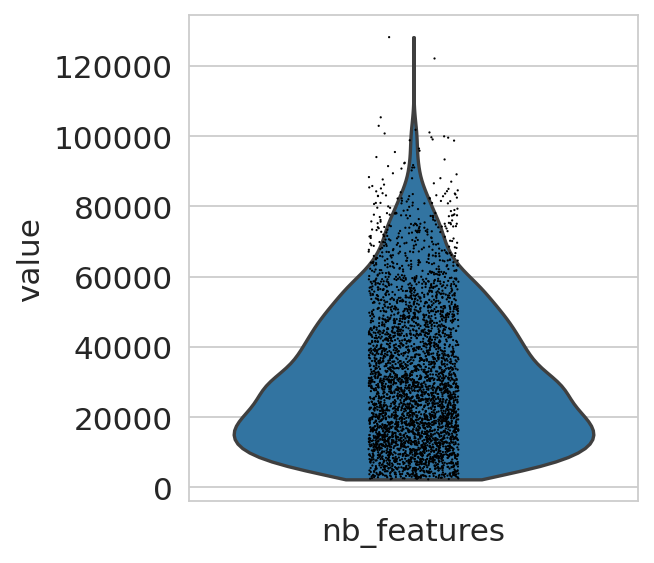

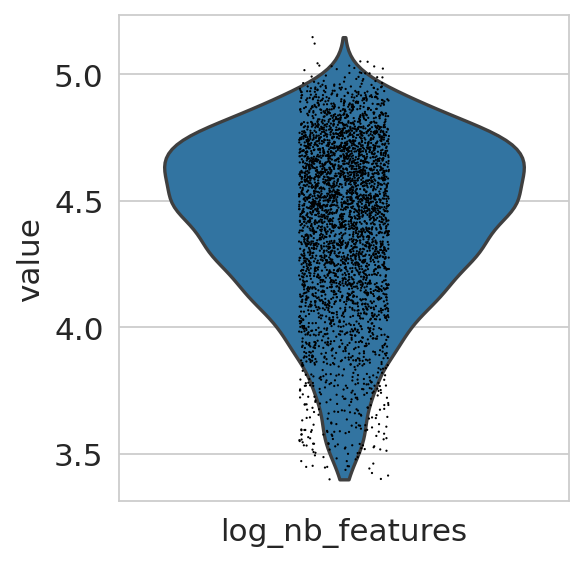

In [23]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [ ]:
epi.pp.lazy(adata)
sc.pl.umap(adata, color=['nb_features'], wspace=0.3)

In [24]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata.layers['counts'] = adata.X.copy()

## Pre-processing large Fang

In [25]:
input_dir_fang = './data_integration_datasets/fang/merged_peaks_large/'

adata2 = ad.read(input_dir_fang+'CEMBA180305_2B_AllCells.h5ad')


adata2

AnnData object with n_obs × n_vars = 88080 × 787157 

In [26]:
adata3 = ad.read(input_dir_fang+'CEMBA180306_2B_AllCells.h5ad')
adata3

adata2 = adata2.concatenate(adata3)

batchname=copy.copy(adata2.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'CEMBA180306_2B', '0' : 'CEMBA180305_2B' })
batchname

adata2.obs['batchname_Fang'] = batchname
adata2

AnnData object with n_obs × n_vars = 176972 × 787157 
    obs: 'batch', 'batchname_Fang'

In [27]:
adata3 = ad.read(input_dir_fang+'CEMBA180226_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180226_1A', regex=False)
adata2

AnnData object with n_obs × n_vars = 263324 × 787157 
    obs: 'batch', 'batchname_Fang'

In [28]:
adata3 = ad.read(input_dir_fang+'CEMBA180227_1A_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180227_1A', regex=False)
adata2

AnnData object with n_obs × n_vars = 341726 × 787157 
    obs: 'batch', 'batchname_Fang'

In [29]:
adata3 = ad.read(input_dir_fang+'CEMBA180308_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180308_3B', regex=False)
adata2

AnnData object with n_obs × n_vars = 434664 × 787157 
    obs: 'batch', 'batchname_Fang'

# adata3 = ad.read(input_dir_fang+'CEMBA180312_3B_AllCells.h5ad')
adata2 = adata2.concatenate(adata3)
adata2.obs['batchname_Fang'] = adata2.obs['batchname_Fang'].replace(np.nan, 'CEMBA180312_3B', regex=False)
adata2

In [31]:
print(np.max(adata2.X))
epi.pp.binarize(adata2)
print(np.max(adata2.X))

150.0
1.0


In [32]:
epi.pp.filter_cells(adata2, min_features=100)
adata2

AnnData object with n_obs × n_vars = 90812 × 787157 
    obs: 'batch', 'batchname_Fang', 'nb_features'

In [33]:
epi.pp.filter_features(adata2, min_cells=10)
adata2

AnnData object with n_obs × n_vars = 90812 × 784975 
    obs: 'batch', 'batchname_Fang', 'nb_features'
    var: 'n_cells'

In [34]:
adata2.obs['log_nb_features'] = [np.log10(x) for x in adata2.obs['nb_features']]
adata2

AnnData object with n_obs × n_vars = 90812 × 784975 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells'

... storing 'batchname_Fang' as categorical


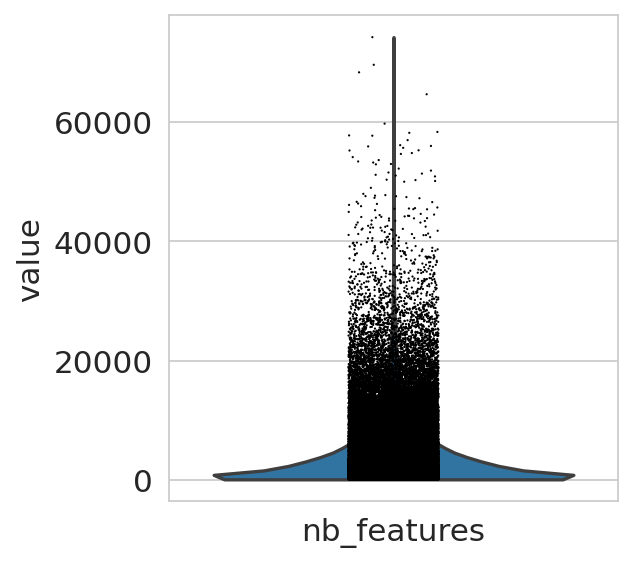

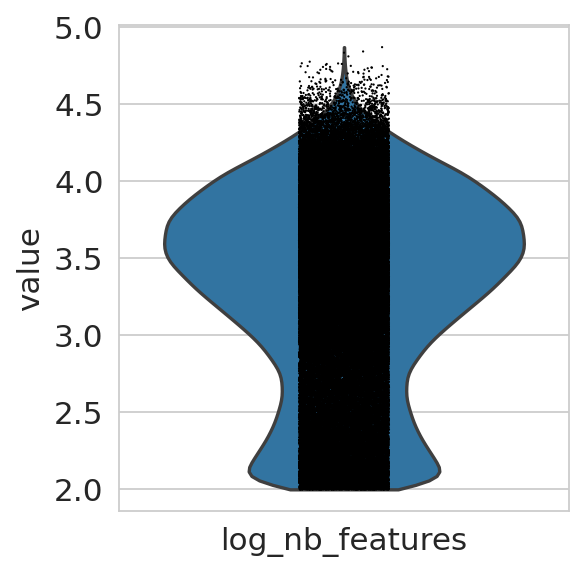

In [35]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

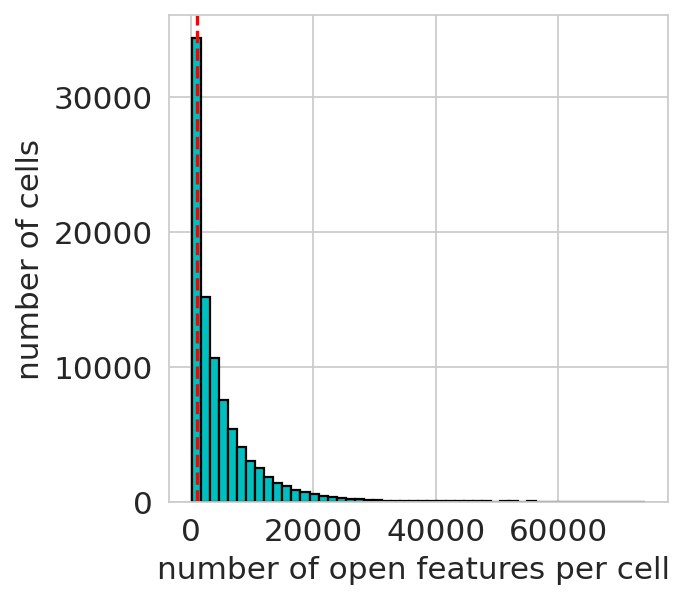

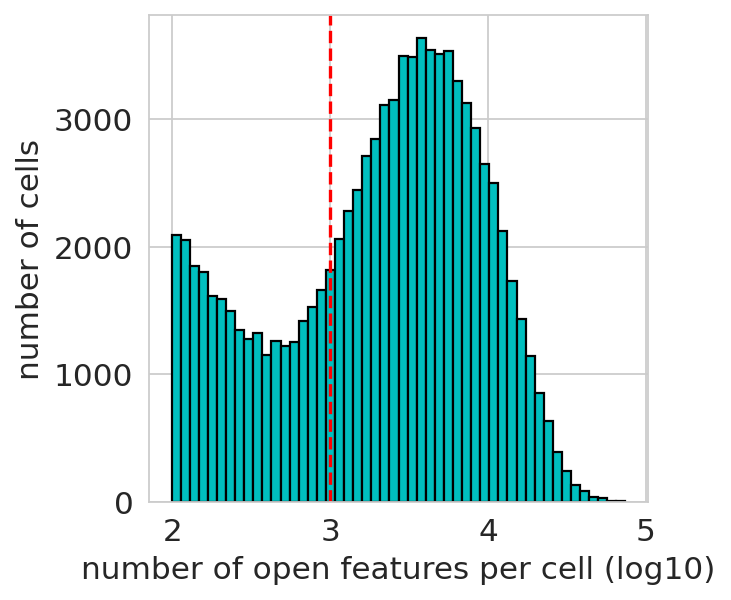

In [36]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata2, binary=True, log=False, bins=50,
               threshold=min_features, save='CEMBA180305_2B_peaks_large_coverage_cells.png')
epi.pp.coverage_cells(adata2, binary=True, log=10, bins=50,
               threshold=min_features, save='CEMBA180305_2B_peaks_large_coverage_cells_log10.png')

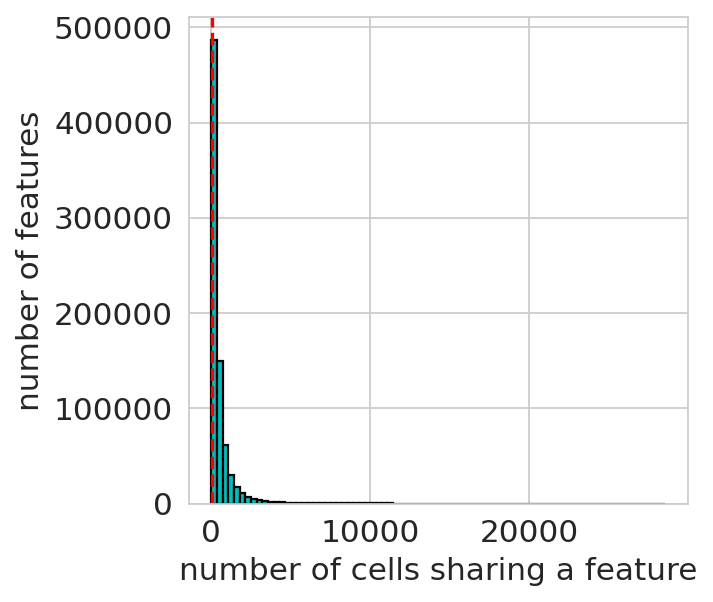

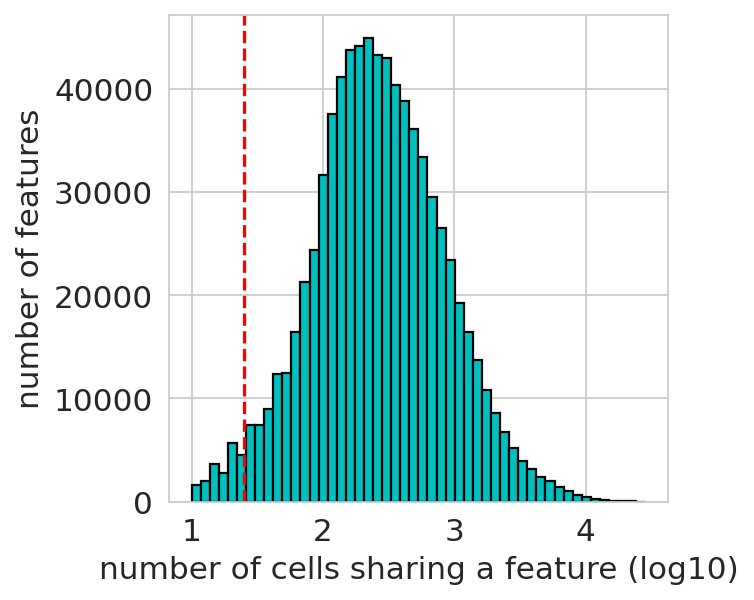

In [37]:
# minimum number of cells sharing a feature
min_cells = 25
epi.pp.coverage_features(adata2, binary=True, log=False, 
                        threshold=min_cells, save='CEMBA180305_2B_peaks_large_coverage.png')
epi.pp.coverage_features(adata2, binary=True, log=True, 
                        threshold=min_cells, save='CEMBA180305_2B_peaks_large_coverage_log10.png')

In [38]:
min_features = 1000
epi.pp.filter_cells(adata2, min_features=min_features)

In [39]:
epi.pp.filter_features(adata2, min_cells=25)
adata2

AnnData object with n_obs × n_vars = 64079 × 764724 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'

### filter features

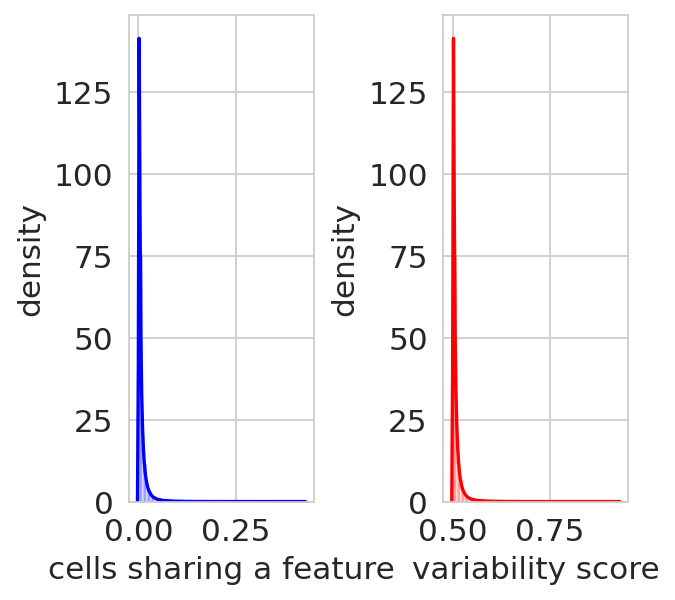

In [40]:
epi.pp.cal_var(adata2)

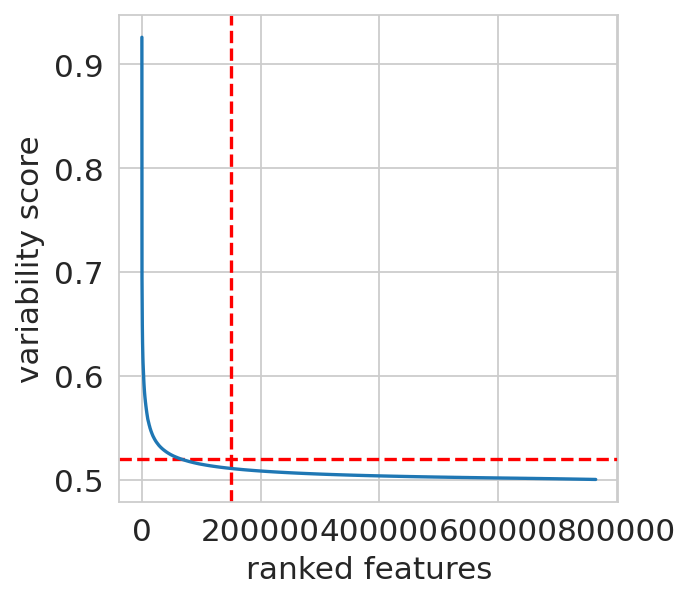

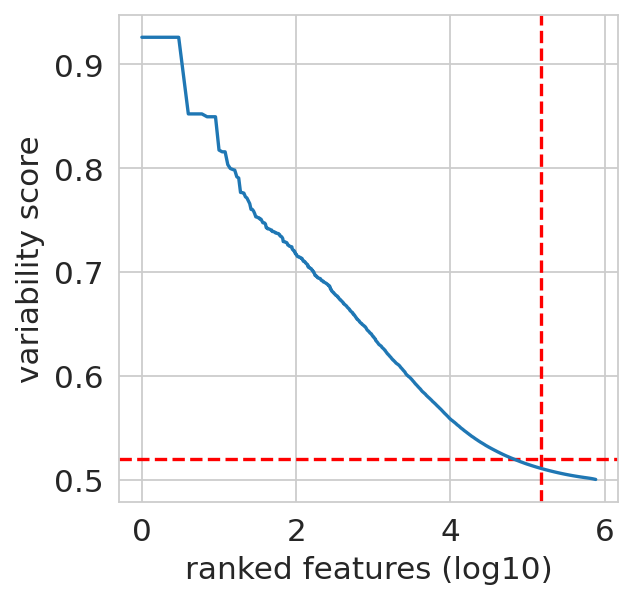

In [41]:
min_score_value = 0.52
nb_feature_selected = 150000
epi.pl.variability_features(adata2,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_peaks_large.png')

epi.pl.variability_features(adata2,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected,
                     save='variability_features_plot_CEMBA180305_2B_peaks_large_log10.png')

In [42]:
# save the current matrix in the raw layer
adata2.raw = adata2

In [43]:
# create a new AnnData containing only the most variable features
adata2 = epi.pp.select_var_feature(adata2,
                                  nb_features=nb_feature_selected,
                                  show=False,
                                  copy=True)

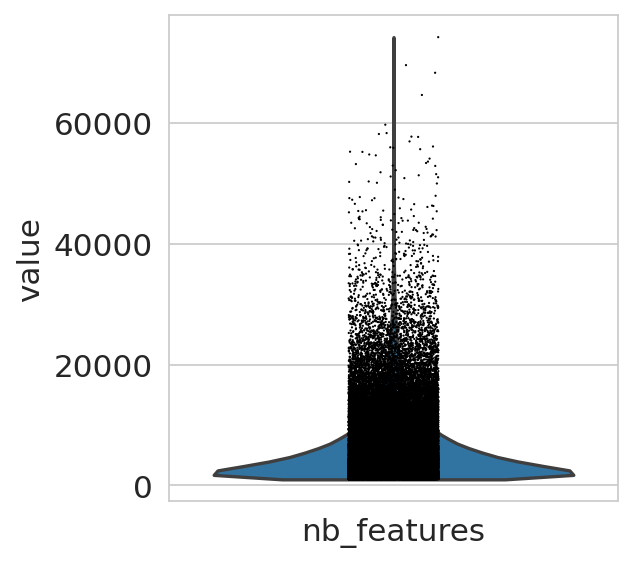

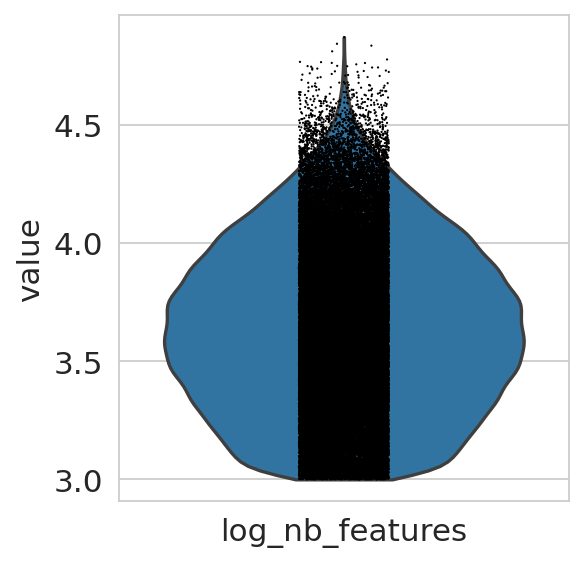

In [44]:
epi.pl.violin(adata2, ['nb_features'])
epi.pl.violin(adata2, ['log_nb_features'])

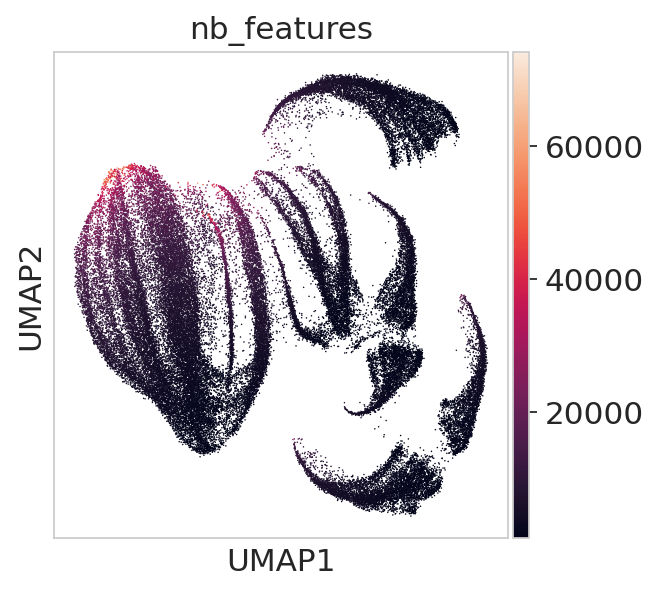

In [47]:
epi.pp.lazy(adata2)
sc.pl.umap(adata2, color=['nb_features'], wspace=0.3)

In [45]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata2.layers['counts'] = adata2.X.copy()
adata2

AnnData object with n_obs × n_vars = 64079 × 150260 
    obs: 'batch', 'batchname_Fang', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness', 'prop_shared_cells', 'variability_score'
    layers: 'counts'

## Pre processing Cusanovich small

In [46]:
input_dir_Cusanovich = './data_integration_datasets/cusanovich/merged_peaks_large/'

In [47]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819246_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819247_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adata3 = adatacus1.copy()
adata3.X = adata3.X+adatacus2.X


del adata3.obs['filter'], adatacus1, adatacus2

adata3

AnnData object with n_obs × n_vars = 35018 × 787157 

In [48]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819248_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819249_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2




adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'WholeBrainA_62816', '0' : 'WholeBrainA_62216' })
batchname

adata3.obs['batchname_Cusanovich'] = batchname
adata3.obs['batchname'] = batchname
adata3

AnnData object with n_obs × n_vars = 52512 × 787157 
    obs: 'batch', 'batchname_Cusanovich', 'batchname'

In [49]:
adata3

AnnData object with n_obs × n_vars = 52512 × 787157 
    obs: 'batch', 'batchname_Cusanovich', 'batchname'

In [50]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819238_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819239_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'PreFrontalCortex_62216', regex=False)


In [51]:
adata3

AnnData object with n_obs × n_vars = 85352 × 787157 
    obs: 'batch', 'batchname', 'batchname_Cusanovich'

In [52]:
adatacus1 = ad.read(input_dir_Cusanovich+'SRR6819220_AllCells.h5ad')
adatacus1

adatacus2 = ad.read(input_dir_Cusanovich+'SRR6819221_AllCells.h5ad')
adatacus2

## First I will add the barcodes present in the 2 files
barcodes1 = adatacus1.obs_names.tolist()
barcodes2 = adatacus2.obs_names.tolist()

annot = []
for line in barcodes1:
    if line in barcodes2:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus1.obs['filter'] = annot

annot = []
for line in barcodes2:
    if line in barcodes1:
        annot.append('keep')
    else:
        annot.append('discard')
adatacus2.obs['filter'] = annot


adatacus1 = adatacus1[adatacus1.obs['filter']=='keep',:].copy()
adatacus1

adatacus2 = adatacus2[adatacus2.obs['filter']=='keep',:].copy()
adatacus2


adatatmp = adatacus1.copy()
adatatmp.X = adatatmp.X+adatacus2.X


del adatatmp.obs['filter'], adatacus1, adatacus2


adata3 = adata3.concatenate(adatatmp)

batchname=copy.copy(adata3.obs['batch'])
batchname

adata3.obs['batchname_Cusanovich'] = adata3.obs['batchname_Cusanovich'].replace(np.nan, 'Cerebellum_62216', regex=False)
adata3.obs['batchname'] = adata3.obs['batchname'].replace(np.nan, 'Cerebellum_62216', regex=False)



In [53]:
adata3

AnnData object with n_obs × n_vars = 103393 × 787157 
    obs: 'batch', 'batchname', 'batchname_Cusanovich'

In [54]:
print(np.max(adata3.X))
epi.pp.binarize(adata3)
print(np.max(adata3.X))

402.0
1.0


In [55]:
# remove any potential empty features or barcodes
epi.pp.filter_cells(adata3, min_features=1)
epi.pp.filter_features(adata3, min_cells=1)
adata3

AnnData object with n_obs × n_vars = 101256 × 787157 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'nb_features'
    var: 'n_cells'

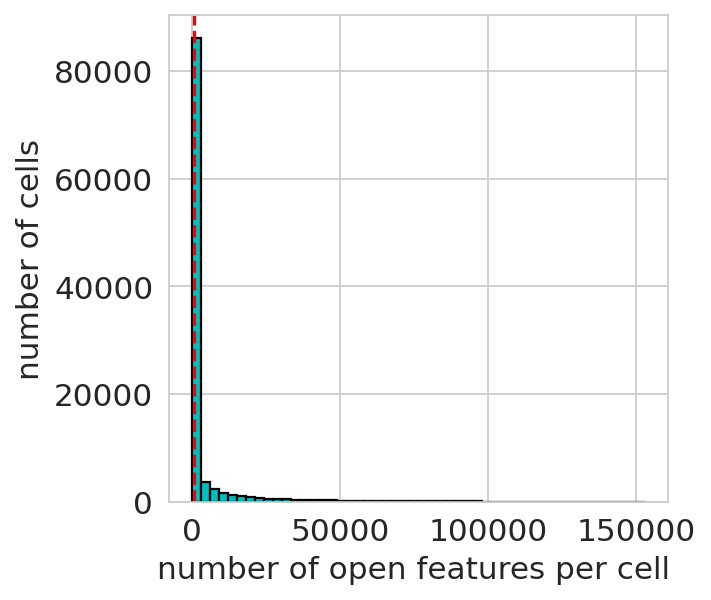

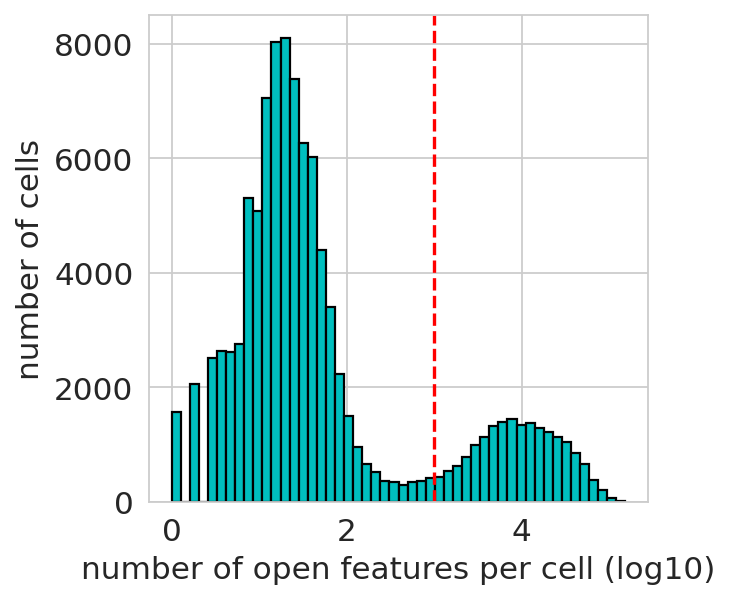

In [56]:
# set a minimum number of cells to keep 
min_features = 1000

epi.pp.coverage_cells(adata3, binary=True, log=False, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_peaks_large.png')
epi.pp.coverage_cells(adata3, binary=True, log=10, bins=50,
               threshold=min_features, save='Cusanovich_coverage_cells_peaks_large_log10.png')

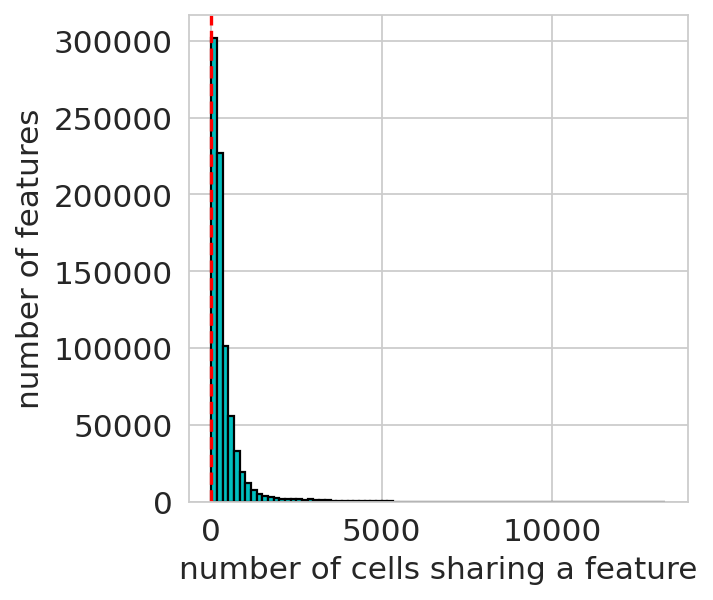

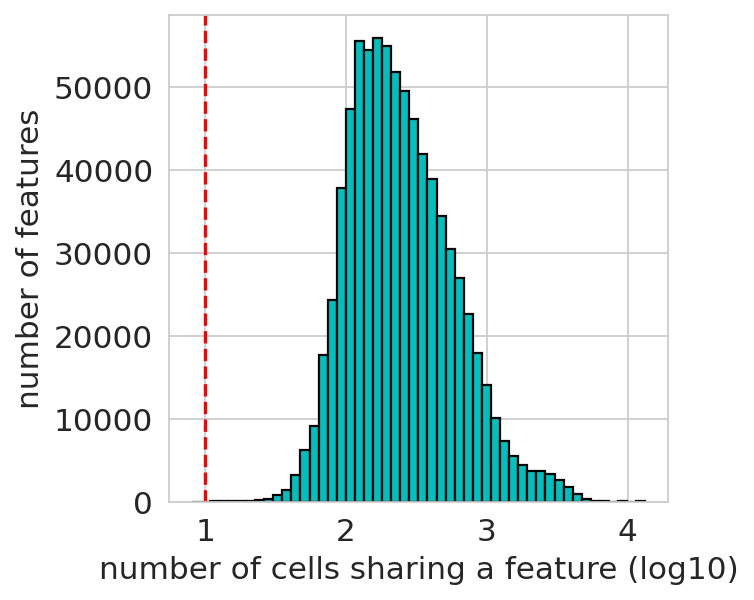

In [57]:
# minimum number of cells sharing a feature
min_cells = 10
epi.pp.coverage_features(adata3, binary=True, log=False, 
                        threshold=min_cells)
epi.pp.coverage_features(adata3, binary=True, log=True, 
                        threshold=min_cells)

In [58]:
min_features = 1000
epi.pp.filter_cells(adata3, min_features=min_features)

In [59]:
min_cells = 10
epi.pp.filter_features(adata3, min_cells=min_cells)

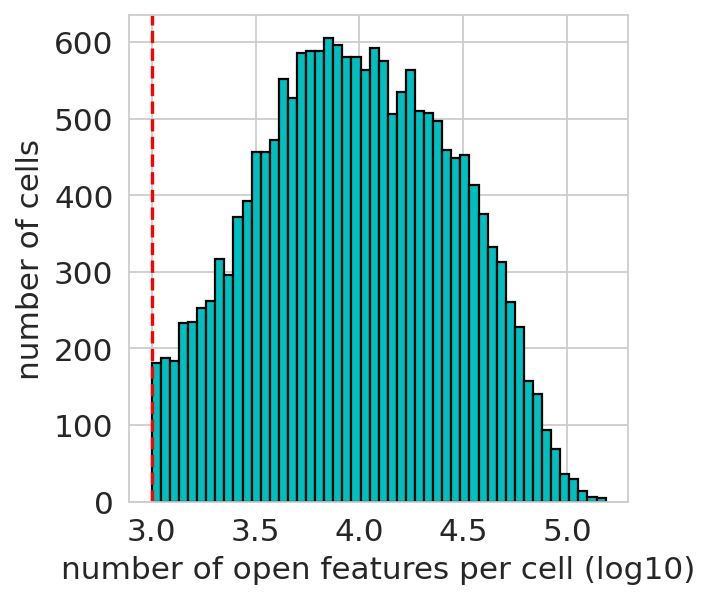

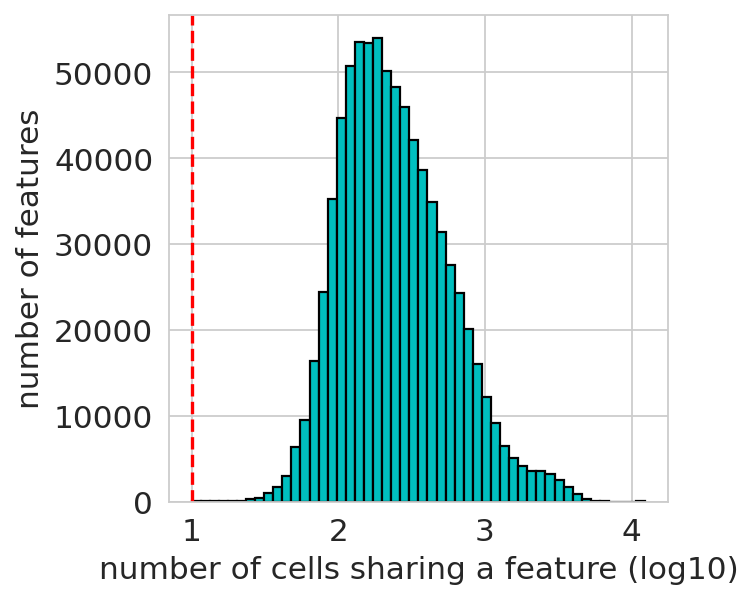

In [60]:
epi.pp.coverage_cells(adata3, binary=True, log='log10', bins=50, threshold=min_features)
epi.pp.coverage_features(adata3, binary=True, log='log10', bins=50, threshold=min_cells)



### filter features

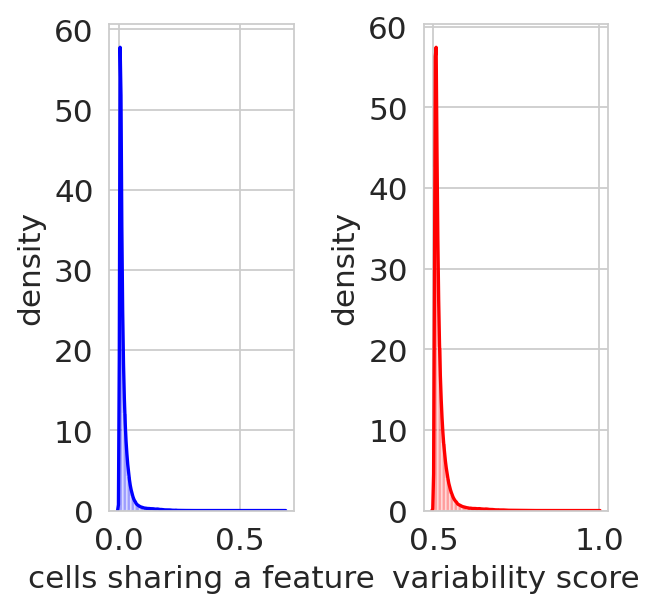

In [61]:
epi.pp.cal_var(adata3)

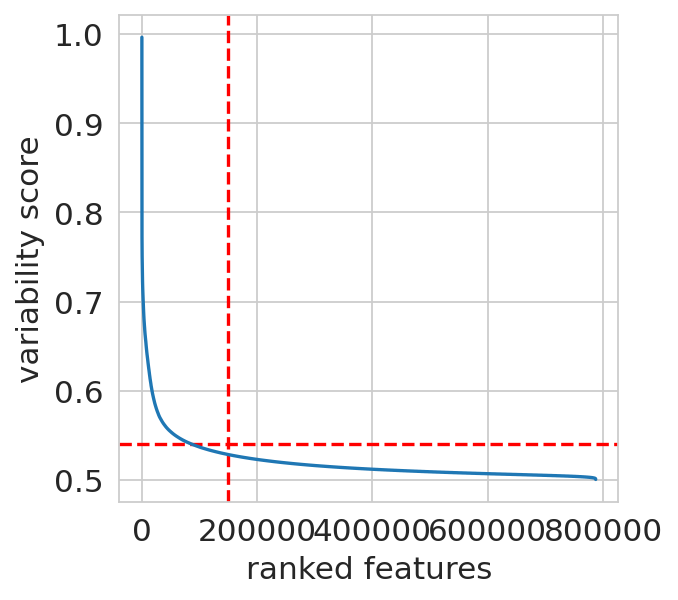

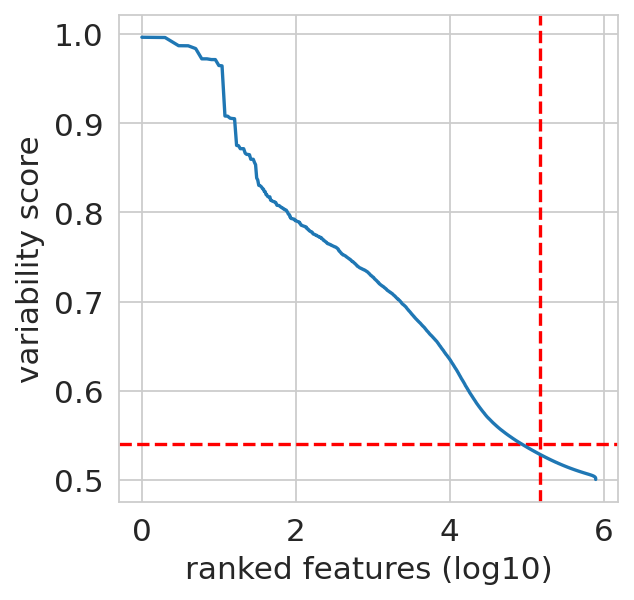

In [62]:
min_score_value = 0.54
nb_feature_selected = 150000
epi.pl.variability_features(adata3,log=None,
                     min_score=min_score_value, nb_features=nb_feature_selected)

epi.pl.variability_features(adata3,log='log10',
                     min_score=min_score_value, nb_features=nb_feature_selected)

In [63]:
# save the current matrix in the raw layer
adata3.raw = adata3

In [64]:
# create a new AnnData containing only the most variable features
adata3 = epi.pp.select_var_feature(adata3,
                            nb_features=nb_feature_selected,
                            show=False,
                            copy=True)

In [65]:
# save the current version of the matrix (binary, not normalised) in a layer of the Anndata.
adata3.layers['counts'] = adata3.X.copy()

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical


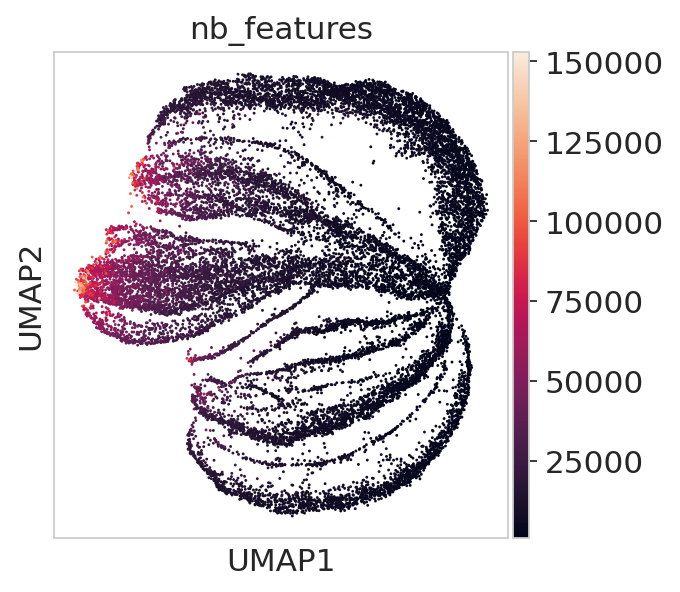

In [84]:
epi.pp.lazy(adata3)
sc.pl.umap(adata3, color=['nb_features'], wspace=0.3)

# merged datasets

In [66]:
adatamerged = adata.concatenate(adata2)
batchname=copy.copy(adatamerged.obs['batch'])
batchname

batchname = batchname.map({ '1' : 'Fang et al.', '0' : '10x Genomics' })
batchname

adatamerged.obs['batchname'] = batchname
adatamerged

AnnData object with n_obs × n_vars = 67818 × 113497 
    obs: 'batch', 'batchname_Fang', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features', 'batchname'
    var: 'n_cells-0', 'commonness-0', 'prop_shared_cells-0', 'variability_score-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'counts'

... storing 'batchname_Fang' as categorical
... storing 'filter_barcode_cellranger' as categorical


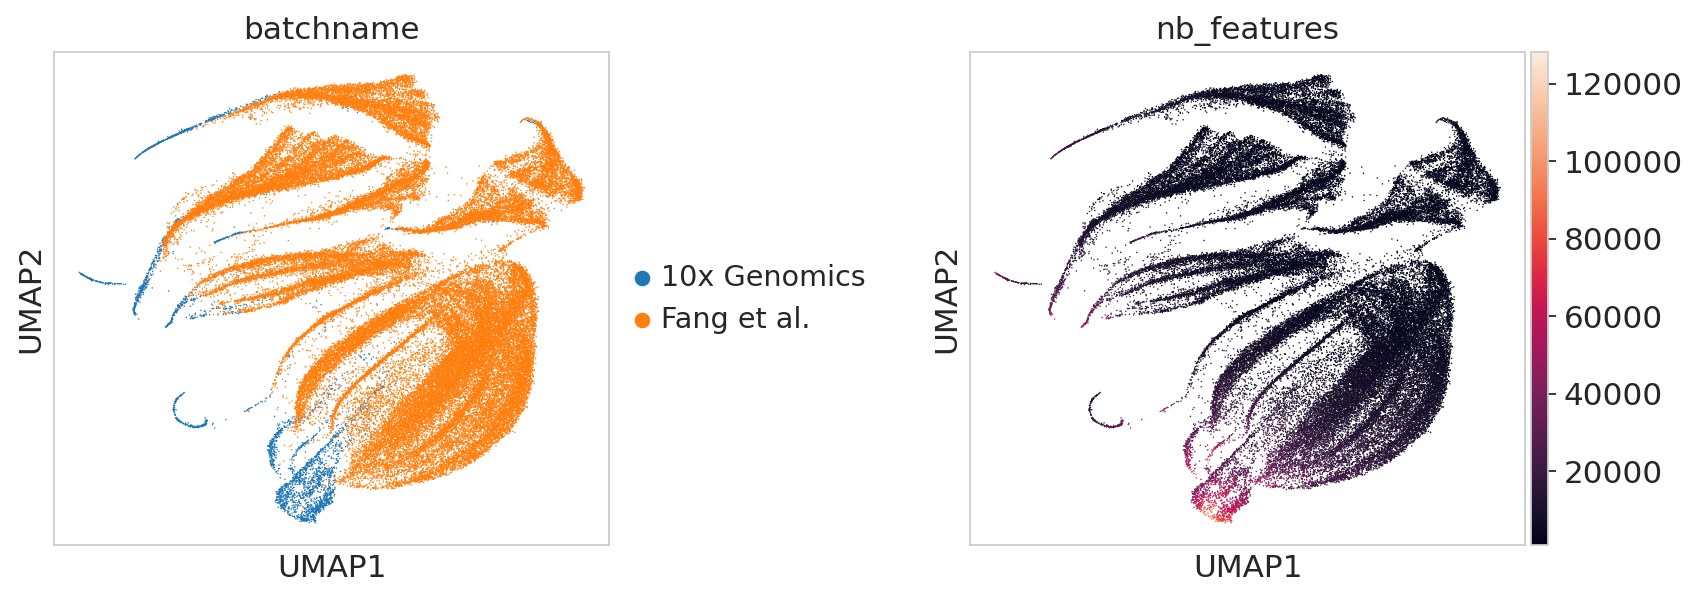

In [88]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [67]:
adatamerged = adatamerged.concatenate(adata3)
adatamerged.obs['batchname'] = adatamerged.obs['batchname'].replace(np.nan, 'Cusanovich et al.', regex=False)
adatamerged

AnnData object with n_obs × n_vars = 86003 × 96924 
    obs: 'batch', 'batchname', 'batchname_Cusanovich', 'batchname_Fang', 'filter_barcode_cellranger', 'log_nb_features', 'nb_features'
    var: 'n_cells-0-0', 'commonness-0-0', 'prop_shared_cells-0-0', 'variability_score-0-0', 'n_cells-1-0', 'commonness-1-0', 'prop_shared_cells-1-0', 'variability_score-1-0', 'n_cells-1', 'commonness-1', 'prop_shared_cells-1', 'variability_score-1'
    layers: 'counts'

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical
... storing 'batchname_Fang' as categorical
... storing 'filter_barcode_cellranger' as categorical


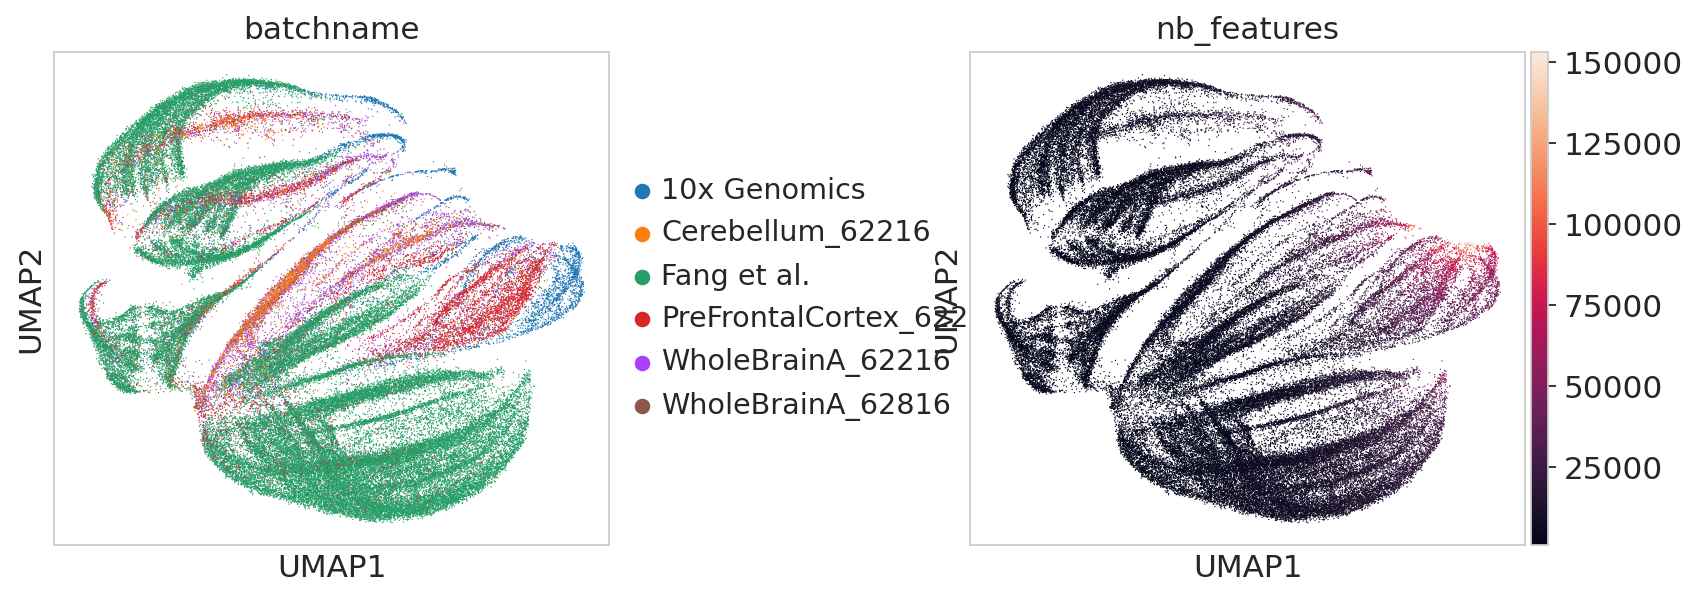

In [90]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [68]:
epi.pp.filter_cells(adatamerged, min_features=500)

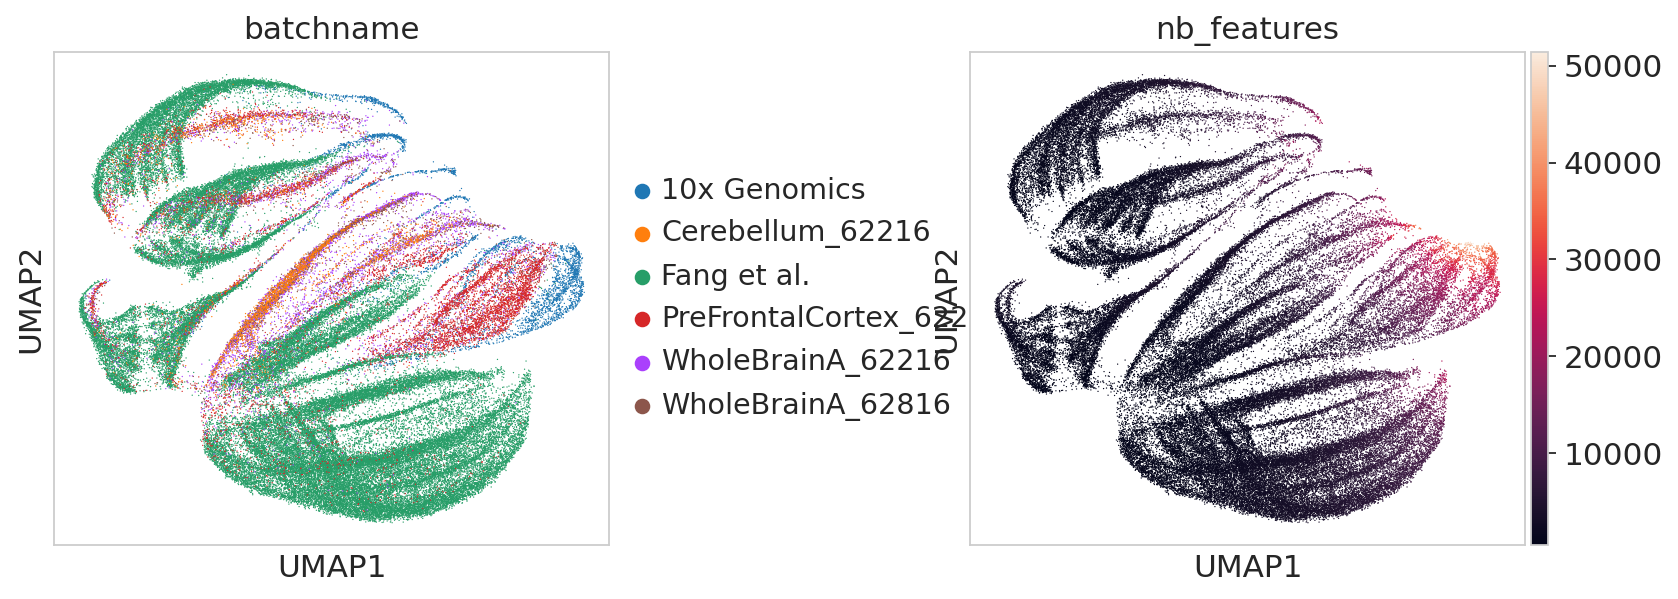

In [91]:
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [69]:
epi.pp.normalize_per_cell(adatamerged)

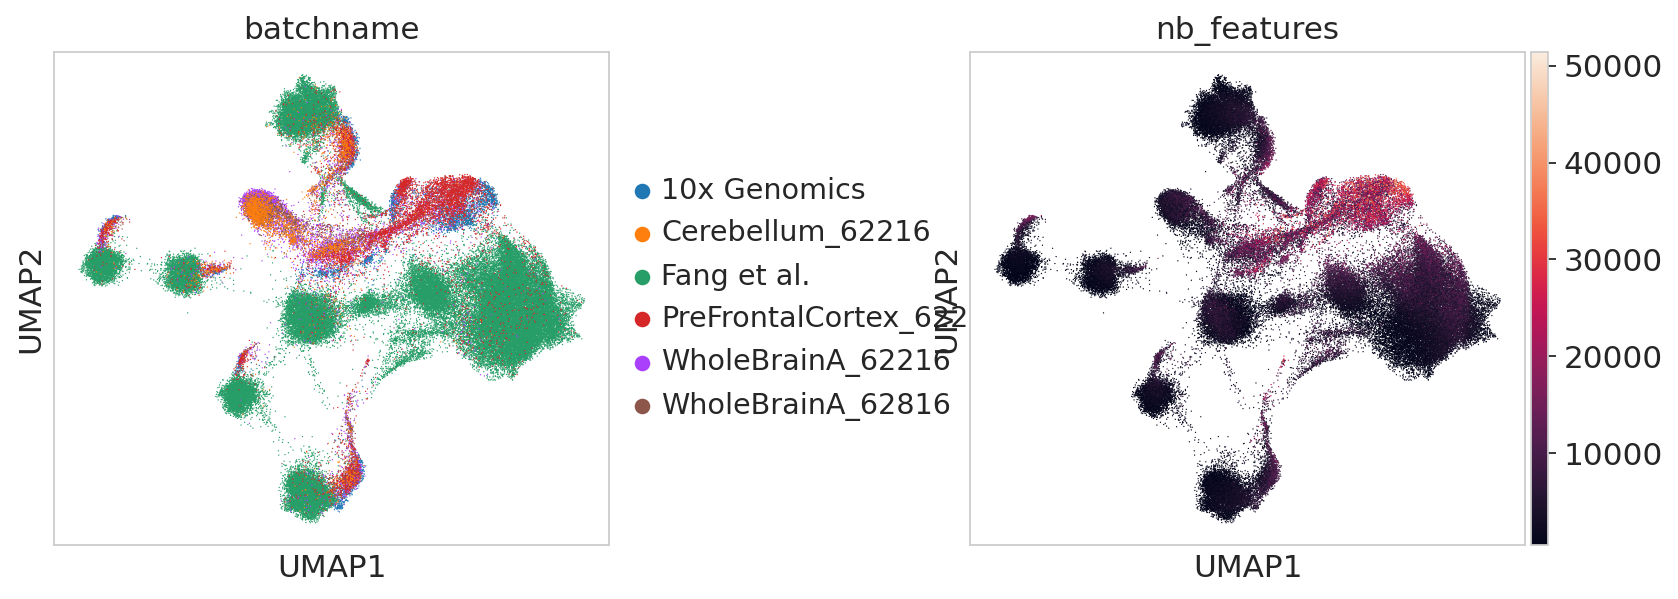

In [92]:
epi.pp.lazy(adatamerged)
sc.pl.umap(adatamerged, color=['batchname', 'nb_features'], wspace=0.5)

In [70]:
adatamerged.write('large_peaks_dataset_merged_dataset.h5ad')

... storing 'batchname' as categorical
... storing 'batchname_Cusanovich' as categorical
... storing 'batchname_Fang' as categorical
... storing 'filter_barcode_cellranger' as categorical
